In [ ]:
!pip install torch torchvision

In [ ]:

import torch
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  

True
Tesla T4


In [1]:
from google.colab import files
uploaded = files.upload()

Saving Reversed_VZ_Data_with_PCA.csv to Reversed_VZ_Data_with_PCA.csv


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm


data = pd.read_csv('Reversed_VZ_Data_with_PCA.csv')
#print(data)
features = data[['open', 'high', 'low', 'close', 'volume','Principal Component 1','Principal Component 2']].values


scaler = MinMaxScaler()


train_ratio = 0.8
split_idx = int(len(features) * train_ratio)
split_idx = round(split_idx / 32) * 32


start=0


X_train = features[start:start+split_idx]  
X_test = features[start+split_idx:len(features)]

scaler.fit(X_train)


X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


result_vstack = np.vstack([X_train_normalized, X_test_normalized])






def create_sequences(data, seq_length, original):
    sequences = []
    labels = []
    actual_values=[]
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])

        labels.append(features[i+seq_length, 3]/features[i+seq_length-1,3])  
        actual_values.append([features[i+seq_length-1, 3],features[i+seq_length, 3]])

    return np.array(sequences), np.array(labels),np.array(actual_values)

seq_length = 30  
X, y, z = create_sequences(result_vstack, seq_length,features)

print(X.shape)
print(y.shape)
print(z.shape)


X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

split_idx = int(len(y) * train_ratio)
split_idx = round(split_idx / 32) * 32
start=len(y)%32



X_train = X[start:start+split_idx]  
y_train = y[start:start+split_idx]
X_test = X[start+split_idx:len(y)]
y_test = y[start+split_idx:len(y)]
z_train = z[start:start+split_idx]
z_test = z[start+split_idx:len(y)]








(2519, 30, 7)
(2519,)
(2519, 2)


 20%|██        | 10/50 [00:08<00:29,  1.34it/s]

Epoch [10/50], Loss: 1.3893514872


 40%|████      | 20/50 [00:15<00:22,  1.34it/s]

Epoch [20/50], Loss: 1.0119767189


 60%|██████    | 30/50 [00:23<00:14,  1.34it/s]

Epoch [30/50], Loss: 1.1550757885


 80%|████████  | 40/50 [00:30<00:08,  1.19it/s]

Epoch [40/50], Loss: 1.0264393091


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]

Epoch [50/50], Loss: 0.5982798338
480
480


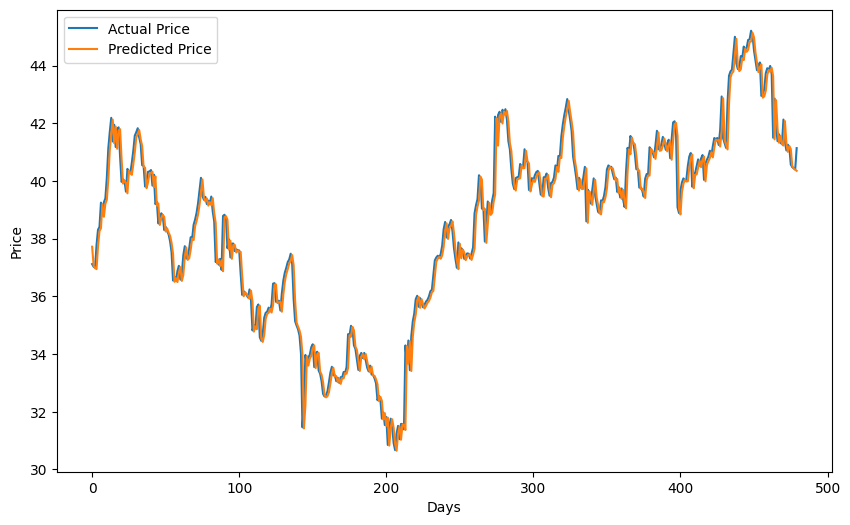

Results saved to 'actuals_vs_predictions.csv'


In [ ]:




train_data = TensorDataset(X_train, y_train,z_train)
test_data = TensorDataset(X_test, y_test,z_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=False)


class GRUModel(nn.Module):
    def __init__(self, input_size=7, hidden_size=500, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1000)  
        self.fc2 = nn.Linear(1000, 2000)          
        self.fc3 = nn.Linear(2000, 4000)  
        self.fc4 = nn.Linear(4000,output_size)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        self.hidden_state=None

    def forward(self, x,hidden):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        if self.hidden_state is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        else:
            h0 = self.hidden_state
            h0  = h0.detach()

        out, self.hidden_state = self.gru(x, h0)
        #print(out.shape)
        out = self.fc1(out[:, -1, :])
        out = torch.relu(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = torch.relu(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        out = torch.relu(out)
        out = self.dropout3(out)

        out = self.fc4(out)
        hidden=self.hidden_state
        return out, hidden


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 50
hidden=None


model.train()
for epoch in tqdm(range(epochs)):
    for X_batch, y_batch, z_batch in train_loader:
        #print(X_batch.shape)
        X_batch, y_batch , z_batch = X_batch.to(device), y_batch.to(device),z_batch.to(device)

        optimizer.zero_grad()
        output, hidden = model(X_batch, hidden)

        #print("output")
        #print(output*100000)
        y_batch = y_batch.view(-1, 1)
        #print(y_batch)
        #print(output.shape)
        loss = criterion(output[:,0]  * z_batch[:,0], z_batch[:,1])
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.10f}")


model.eval()
predictions = []
actuals = []

with torch.no_grad():
    #print(len(X_batch))
    for X_batch, y_batch, z_batch in test_loader:
        #print(X_batch)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output, hidden = model(X_batch, hidden)
        #print("X_batch")
        #print(X_batch)
        #print("output")
        #print(output)
        pre= output.cpu().numpy()[:,0]  * z_batch.cpu().numpy()[:,0]
        #print(output)
        #print(z_batch.shape)
        #print(pre.shape)
        predictions.extend(pre )
        actuals.extend(z_batch.cpu().numpy()[:,1])


all_elements=[]
for arr in predictions:
    for elem in arr.flat:  
        all_elements.append(elem)

predictions=all_elements[0:len(actuals)]
print(len(predictions))
print(len(actuals))





plt.figure(figsize=(10,6))
plt.plot(actuals, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


#torch.save(model.state_dict(), 'stock_gru_model.pth')

data['timestamp'] = pd.to_datetime(data['timestamp'])


dates = data['timestamp'].values[-len(actuals):]  


results_df = pd.DataFrame({
    'timestamp': dates,
    'Actual Price': actuals,
    'Predicted Price': predictions
})


results_df.to_csv('actuals_vs_predictions.csv', index=False)
print("Results saved to 'actuals_vs_predictions.csv'")


In [4]:
from google.colab import files
#files.download("stock_gru_model.pth")
files.download("actuals_vs_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>